In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.util import add_cyclic

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-lh" / "data.nc")
ERA5_LH = ERA5["slhf"].sel(valid_time="2024-04-02T12:00:00")
ERA5_LSM = ERA5["lsm"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
# Prepare data for plotting
Lon, Lat = np.meshgrid(ERA5_LH["longitude"], ERA5_LH["latitude"])
Data = ERA5_LH.data
Data_p, Lon_p, Lat_p = add_cyclic(Data, x=Lon, y=Lat, precision=0.00001)

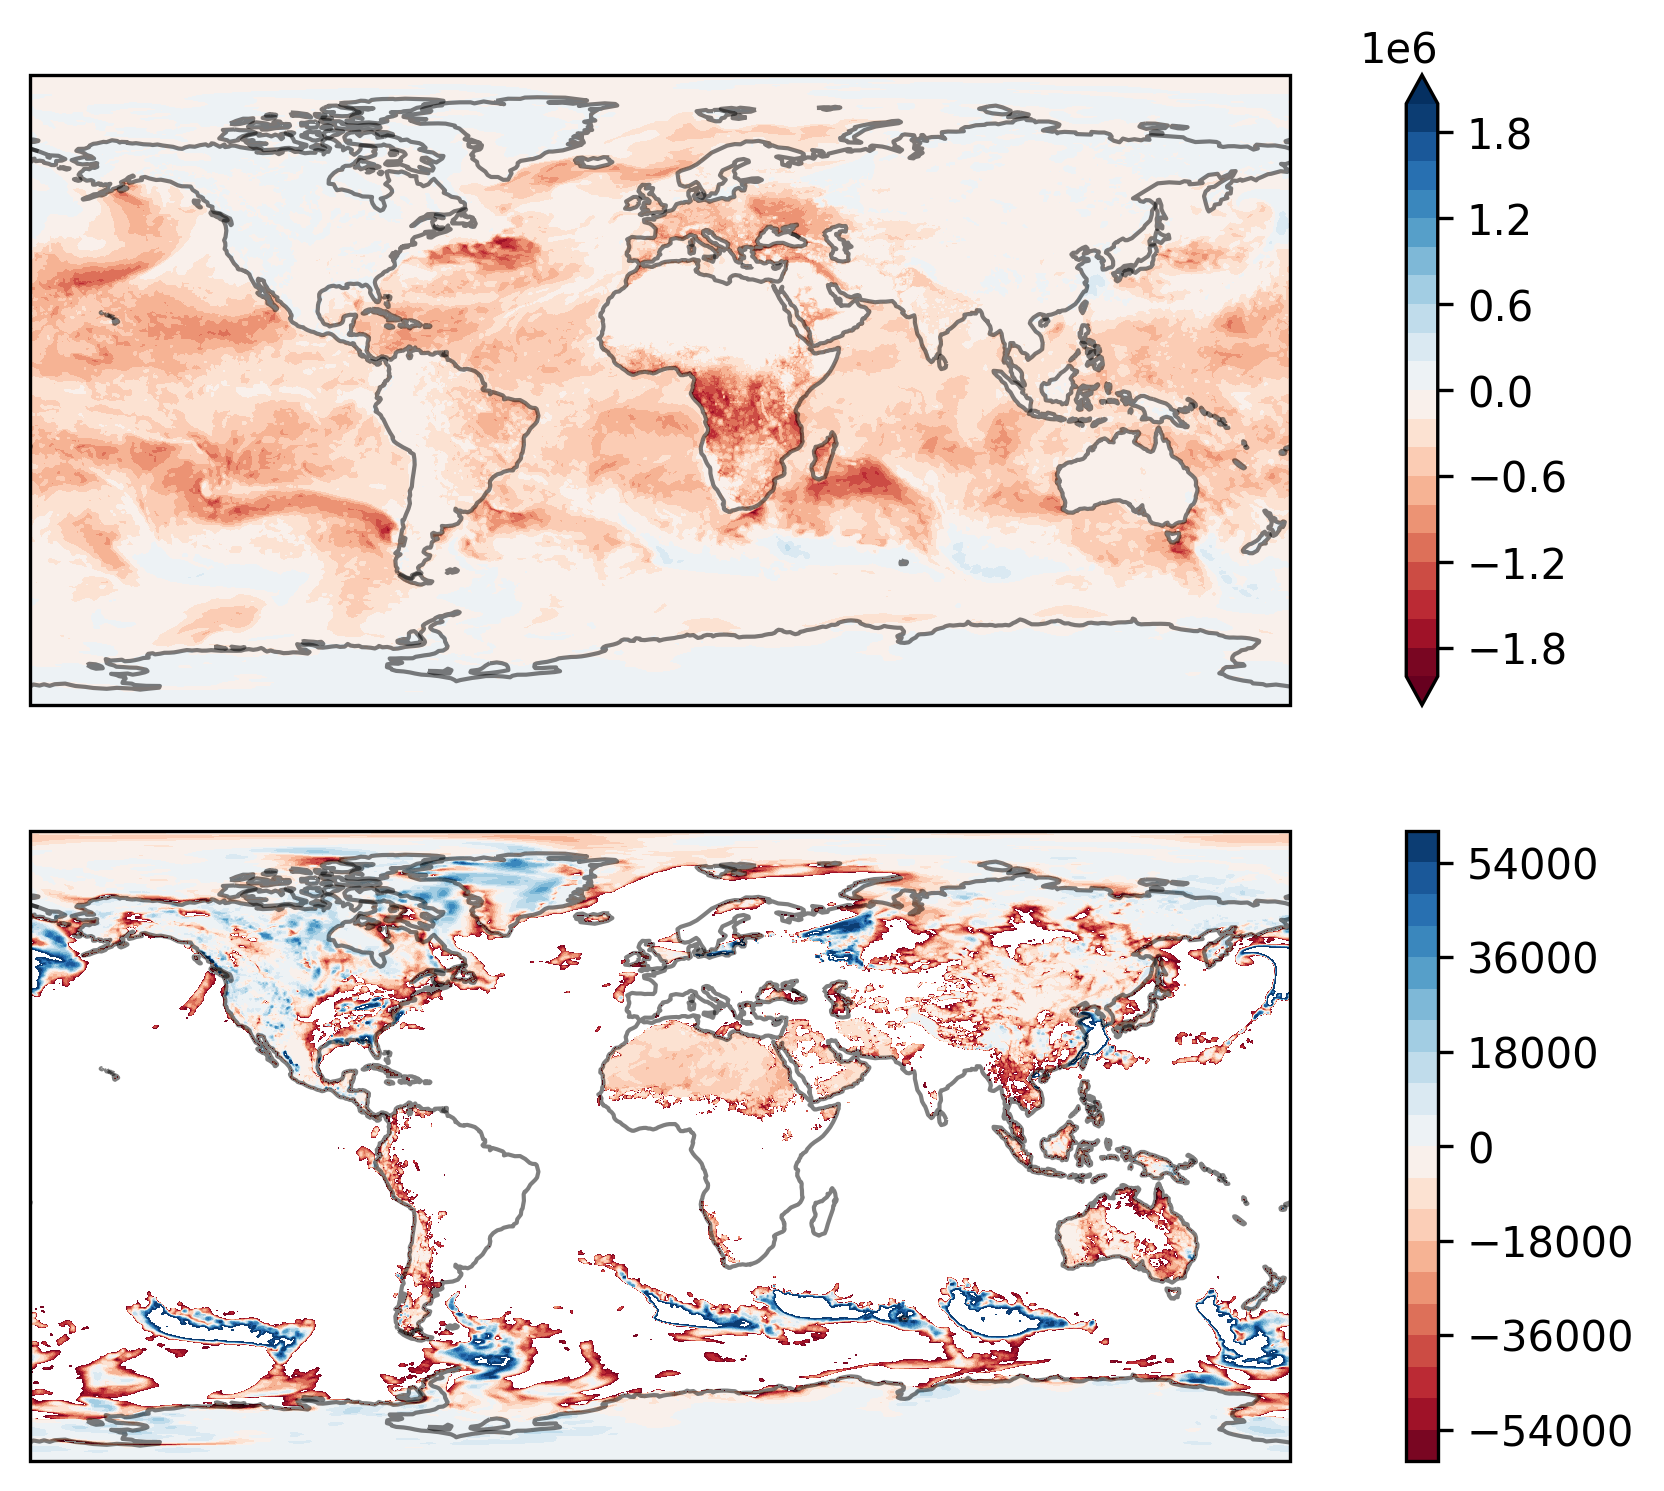

In [5]:
# Plotting
fig = plt.figure(figsize=(10, 6), dpi=300)
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())


im1 = ax1.contourf(
    Lon_p,
    Lat_p,
    Data_p,
    transform=ccrs.PlateCarree(),
    cmap="RdBu",
    extend="both",
    levels=np.arange(-2.0, 2.01, 0.2) * 1e6,
)

cb1 = plt.colorbar(im1, ax=ax1)
ax1.coastlines(alpha=0.5)

im2 = ax2.contourf(
    Lon_p,
    Lat_p,
    Data_p,
    transform=ccrs.PlateCarree(),
    cmap="RdBu",
    extend="neither",
    levels=np.arange(-6.0, 6.01, 0.6) * 1e4,
)

cb2 = plt.colorbar(im2, ax=ax2)
ax2.coastlines(alpha=0.5)

plt.show()

In [6]:
import earthkit.plots

In [7]:
import copy

def plot_data(da: xr.DataArray, title_prefix="", title_postfix="", error=False, n_levels=256):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)
    
    units = None if error else UNITS.get(da.name, None)
    divergence_point = 0.0 if error else DIVERGENCE_POINT.get(da.name, None)

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(earthkit.plots.styles.auto.guess_style(
        source, units=units or source.units,
    ))

    da_units = style.convert_units(da.values, source.units)
    
    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        earthkit.plots.styles.levels.auto_range(
            da_units, divergence_point=divergence_point, n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = earthkit.plots.styles.levels.auto_range(
        da_units, divergence_point=divergence_point, n_levels=10,
    )

    # force the colourmap to coolwarm for error plots
    style._colors = "coolwarm" if error else style._colors

    chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da, units=units, style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    chart.show()

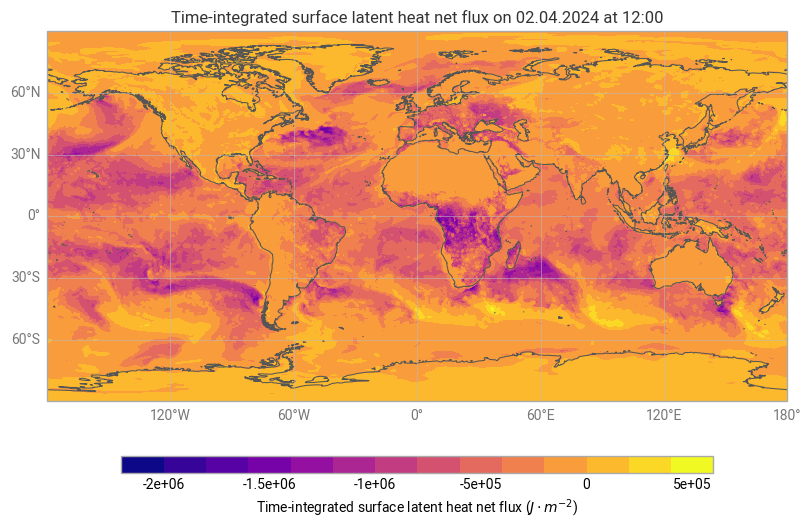

In [8]:
plot_data(ERA5_LH, n_levels=20)

In [9]:
from numcodecs_wasm_zfp import Zfp

In [10]:
zfp = Zfp(mode="fixed-accuracy", tolerance=2e1)

encoded_zfp = zfp.encode(ERA5_LH.values)
ERA5_LH_zfp = ERA5_LH.copy(data=zfp.decode(encoded_zfp))

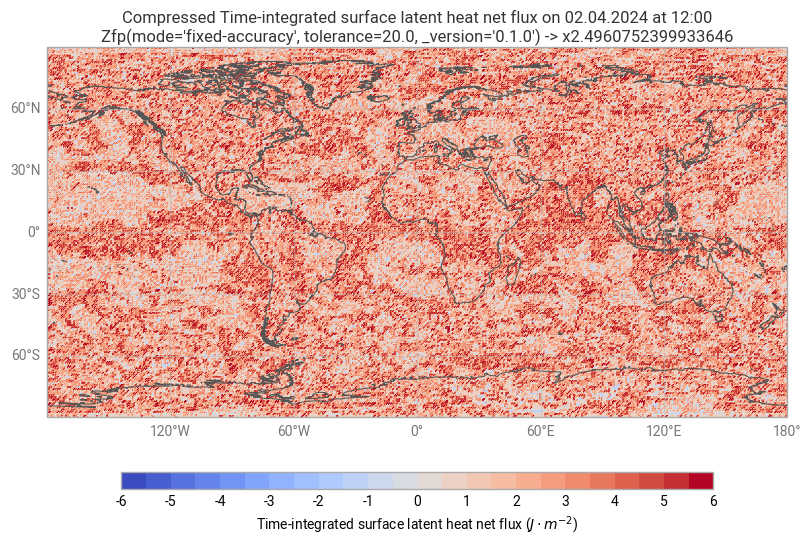

In [11]:
with xr.set_options(keep_attrs=True):
    plot_data(ERA5_LH_zfp - ERA5_LH, title_prefix="Compressed ", title_postfix=f"\n{zfp} -> x{ERA5_LH.nbytes / encoded_zfp.nbytes}", error=True, n_levels=20);

In [12]:
from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings
from numcodecs_safeguards.lossless import _default_lossless_for_safeguards

In [13]:
sg = Safeguards(safeguards=[
    dict(kind="select", selector="lsm", safeguards=[
        # 0: absolute error for >=90% land
        dict(kind="eb", type="abs", eb=2e3),
        # 1: absolute error for <90% land
        dict(kind="eb", type="abs", eb=2e1),
    ]),
])

correction_sg = sg.compute_correction(ERA5_LH.values, np.zeros_like(ERA5_LH.values), late_bound=Bindings(
    # lsm: 1 for >=90% land, 0 otherwise
    lsm=(ERA5_LSM >= 0.9).values,
))
encoded_sg = _default_lossless_for_safeguards().encode(correction_sg)

ERA5_LH_sg = ERA5_LH.copy(data=sg.apply_correction(np.zeros_like(ERA5_LH.values), correction_sg))

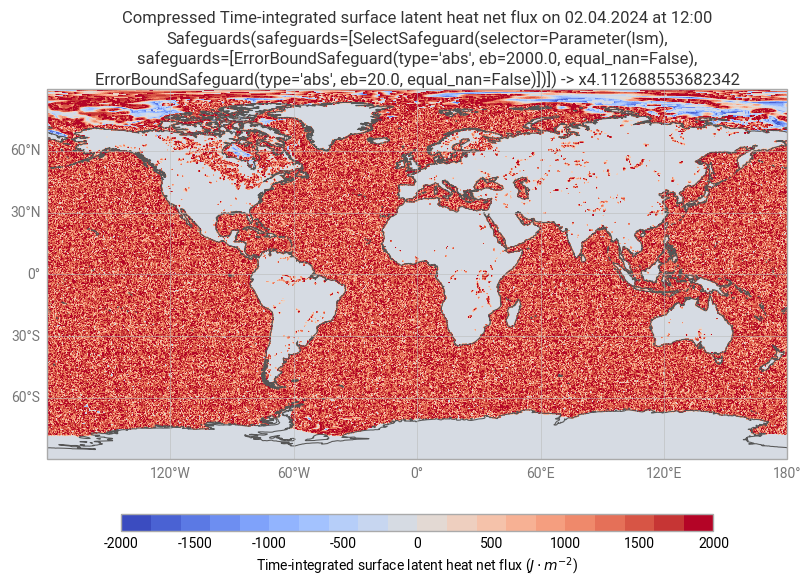

In [14]:
with xr.set_options(keep_attrs=True):
    plot_data(ERA5_LH_sg - ERA5_LH, title_prefix="Compressed ", title_postfix=f"\n{sg} -> x{ERA5_LH.nbytes / np.asarray(encoded_sg).nbytes}", error=True, n_levels=20);